In [3]:
## Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from sklearn.svm import SVR

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Table of contents

1. Exploratory Data Analysis
2. Data Preprocessing: Missing values, Replacing values
4. Preparing data + Looking at correlations
3. Defining error function
4. Modelling: Training models + Cross-validation
5. Tuning models: Hyperparameter tuning using Gridsearch (not included)
6. Comparison of different models
7. Test model on test set
8. Further improvements

## 1. Exploratory Data Analysis

For more EDA, refer to combined PDF file which contains in-depth analysis of each predictor.

### Loading dataset

In [4]:
hotels = pd.read_csv("train_set.csv")

In [5]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396487 entries, 0 to 396486
Data columns (total 12 columns):
hotel_id              396487 non-null float64
city_id               395979 non-null float64
content_score         395979 non-null float64
n_images              395978 non-null float64
distance_to_center    395958 non-null float64
avg_rating            286089 non-null float64
stars                 395925 non-null float64
n_reviews             395958 non-null float64
avg_rank              396487 non-null float64
avg_price             396317 non-null float64
avg_saving_percent    396317 non-null float64
n_clicks              396487 non-null int64
dtypes: float64(11), int64(1)
memory usage: 36.3 MB


## 2. Data Preprocessing
Handling missing values and preparing dataset for modelling

#### Dropping hotel_id column

In [6]:
hotels = hotels.drop(['hotel_id'],axis=1)

### N_images

Justification: N_images contains some values with negative number of images (impossible), and very high values (1000+ images), both of which need some alteration.

#### Removing negative values

In [7]:
hotels.n_images = hotels.n_images.replace(to_replace=-1,value=0)

#### Removing all values greater than 250

In [8]:
hotels.loc[hotels.n_images > 250,"n_images"] = 250

### Avg. Rating

#### Filling NA's with 60 avg rating

Justification: By analyzing the training set, most of the NA's in the avg. rating column coincided with very low n_clicks. This is why setting a distinctive average rating well below the average 80, may allow the model to distinguish well between lower ratings and higher ratings.

In [13]:
hotels['avg_rating'].fillna(60,inplace=True)

#### Dropping all other rows with NA

In [17]:
hotels = hotels.dropna()

## 3. Preparing data

In [18]:
features = ['city_id','content_score','n_images','distance_to_center','avg_rating','stars','n_reviews','avg_rank','avg_price','avg_saving_percent']

In [19]:
X = hotels[features]
y = hotels.n_clicks

### Looking for correlations

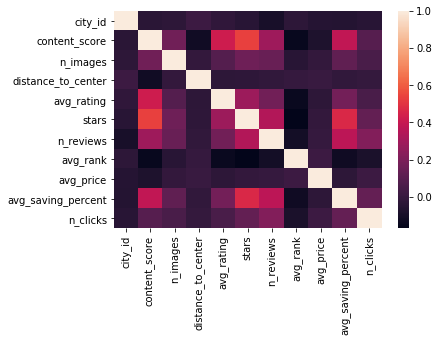

In [20]:
sns.heatmap(hotels.corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116e486d8>,
      dtype=object)

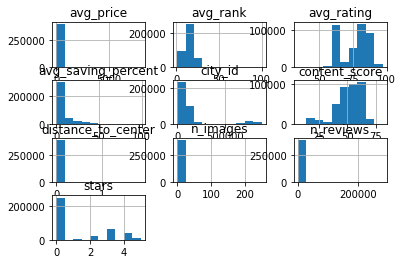

In [21]:
X.hist()

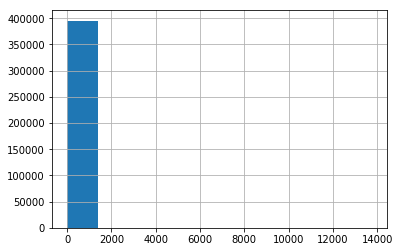

In [22]:
y.hist()

## 4. Defining Error function

In [23]:
def mean_norm_sq_error(y_true,y_pred,**kwargs):
    denom = 0
    nom = 0
    n = len(y_pred)
    y_true_list = []
    for j in y_true:
        y_true_list.append(j)
    for i in range(len(y_pred)):
        w = np.log10(y_true_list[i]+1)+1
        denom = denom + w
        diff = y_pred[i] - y_true_list[i]
        diff_sq = diff**2
        t = diff_sq*w
        nom = nom + t
    error = (1/n)*(t/w)
    return error

In [24]:
mnsq_error = make_scorer(mean_norm_sq_error,greater_is_better=False)

## 5. Modelling

* Random Forest Regressor
* SVR
* Gradient boosting
* Adaboost
* XGBoost

### Splitting into train-test

In [25]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

### Random Forest Regressor

In [26]:
rf = RandomForestRegressor(max_depth = None,n_estimators = 100,min_samples_split=2,n_jobs=-1)

In [64]:
params = {'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 #'max_features': ['auto', 'sqrt'],
 #'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600]}

In [27]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### In-depth look at predictions

In [28]:
y_pred_rf = rf.predict(X_val)

In [29]:
results = pd.DataFrame({"Pred":y_pred_rf,"True":y_val,"Diff":y_pred_rf - y_val,"Diff_squared":(y_pred_rf - y_val)**2})

In [33]:
results[np.abs(results['Diff'])< 10].sort_values(['True'],ascending=False).head()

,Pred,True,Diff,Diff_squared
91373,1174.28,1176,-1.72,2.9584
215413,567.78,576,-8.22,67.5684
134708,380.70,382,-1.30,1.6900
121235,356.34,356,0.34,0.1156
161251,357.92,352,5.92,35.0464


~65000 predictions out of 79000 within 10 clicks of true value.

#### RF Cross-validation

In [69]:
scores_rf = cross_val_score(rf,X,y,scoring=mnsq_error,cv=3,n_jobs=-1)

In [70]:
-1*scores_rf.mean()

3.2970487163937735e-05

### RF Feature Importances

In [34]:
pd.DataFrame({"name":X.columns, "importance":rf.feature_importances_}).sort_values("importance",ascending=False)

,name,importance
0,city_id,0.218441
7,avg_rank,0.184829
6,n_reviews,0.168986
8,avg_price,0.115192
9,avg_saving_percent,0.090191
3,distance_to_center,0.067344
1,content_score,0.044513
2,n_images,0.043211
4,avg_rating,0.041247
5,stars,0.026044


### Support Vector Regressor

Note: SVR does not scale well and takes much time and resources. As a result, it's contributions were not assessed.

In [45]:
svr = SVR(C=10,gamma='auto',epsilon=0.1)

In [ ]:
scores_svr = cross_val_score(svr,X,y,scoring=mnsq_error,cv=3,n_jobs=-1)

In [ ]:
-1*scores_svr.mean()

### Gradient Boosting Regressor

In [35]:
gb = GradientBoostingRegressor(loss = "huber")

In [36]:
gb.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

#### In-depth look at GB Predictions

In [37]:
y_pred_gb = gb.predict(X_val)

In [38]:
results_gb = pd.DataFrame({"Pred":y_pred_gb,"True":y_val,"Diff":y_pred_gb - y_val,"Diff_squared":(y_pred_gb - y_val)**2})

In [41]:
results_gb[np.abs(results_gb['Diff'])< 10].sort_values(['True'],ascending=False).head()

,Pred,True,Diff,Diff_squared
118762,403.757214,412,-8.242786,67.943520
79141,385.417498,394,-8.582502,73.659349
178617,178.624585,184,-5.375415,28.895088
144858,117.309709,124,-6.690291,44.759998
305709,108.741236,114,-5.258764,27.654602


Note: ~70000 predictions within 10 clicks of true value out of 79000.

#### GB Cross-validation

In [43]:
scores_gb = cross_val_score(gb,X,y,scoring=mnsq_error,cv=3,n_jobs=-1)

In [44]:
-1*scores_gb.mean()

9.255592673087257e-05

### GB Feature Importances

In [42]:
pd.DataFrame({"name":X.columns, "importance":gb.feature_importances_}).sort_values("importance",ascending=False)

,name,importance
0,city_id,0.354475
7,avg_rank,0.190363
6,n_reviews,0.137011
9,avg_saving_percent,0.095676
8,avg_price,0.082030
2,n_images,0.054362
5,stars,0.046343
1,content_score,0.031308
3,distance_to_center,0.007531
4,avg_rating,0.000902


### Adaboost

In [45]:
ada = AdaBoostRegressor(n_estimators=100)

In [48]:
ada.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=100, random_state=None)

#### In-depth look at Adaboost predictions

In [50]:
y_pred_ada = ada.predict(X_val)

In [51]:
results_ada = pd.DataFrame({"Pred":y_pred_ada,"True":y_val,"Diff":y_pred_ada - y_val,"Diff_squared":(y_pred_ada - y_val)**2})

In [56]:
results_ada[np.abs(results_ada['Diff'])< 10].sort_values(['True'],ascending=False).head()

,Pred,True,Diff,Diff_squared
5769,665.966862,666,-0.033138,0.001098
316629,463.553704,456,7.553704,57.058438
249981,453.417367,452,1.417367,2.008929
232181,372.543947,366,6.543947,42.823246
162232,344.738725,354,-9.261275,85.771223


Note: ~1600 predictions out of 79000 within 10 clicks of actual value.

#### Adaboost Cross-validation

In [46]:
scores_ada = cross_val_score(ada,X,y,scoring=mnsq_error,cv=3,n_jobs=-1)

In [47]:
-1*scores_ada.mean()

0.004712190455057418

### XGBoost

In [57]:
xgb = XGBRegressor(booster='gbtree',gamma=0,learning_rate=0.099)

In [58]:
xgb.fit(X_train,y_train)

/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:58:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.099, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

#### In depth look at XGB Predictions

In [60]:
y_pred_xb = xgb.predict(X_val)

In [61]:
results_xb = pd.DataFrame({"Pred":y_pred_xb,"True":y_val,"Diff":y_pred_xb - y_val,"Diff_squared":(y_pred_xb - y_val)**2})

In [64]:
results_xb[np.abs(results_xb['Diff'])<10].sort_values(['Diff'],ascending=False).head()

,Pred,True,Diff,Diff_squared
16946,11.999607,2,9.999607,99.992142
277768,9.998839,0,9.998839,99.976791
370292,9.997731,0,9.997731,99.954628
219158,9.997731,0,9.997731,99.954628
184167,43.997349,34,9.997349,99.946983


Note: ~60000 predictions out of 79000 within 10 clicks of true value.

#### XGB Cross validation

In [66]:
scores_xgb_cv = cross_val_score(xgb,X,y,scoring=mnsq_error,cv=3,n_jobs=-1)

/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:01:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:01:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:01:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [67]:
-1*scores_xgb_cv.mean()

0.00010705266963209603

### XGB Feature Importances

In [68]:
pd.DataFrame({"name":X.columns, "importance":xgb.feature_importances_}).sort_values("importance",ascending=False)

,name,importance
0,city_id,0.221721
7,avg_rank,0.213329
6,n_reviews,0.124315
5,stars,0.089395
9,avg_saving_percent,0.086784
8,avg_price,0.078523
4,avg_rating,0.066297
2,n_images,0.063638
1,content_score,0.053823
3,distance_to_center,0.002176


## 6. Comparison of Models

|Model |Weighted Mean SQ_Error (CV=3) |Percentage of predicted clicks within 10 clicks of true value |
|-|-|-|
|Random Forest | **0.000033** | 82% |
|Gradient Boosting (scikit) |0.000092 | **88.6%** |
|AdaBoost (scikit) | 0.004 | 1.8% |
|XGBoost | 0.0001 | 76% |

where MNSQ_Error is the Normalized Weighted Mean Square Error. 

Random Forest achieved the lowest Weighted Normalized Mean Square Error and the GBRegressor achieved the highest number of predictions within 10 clicks of the true value.

## 7. Modelling on the test set

#### Loading the test set

In [125]:
test_set = pd.read_csv("test_set.csv")

#### Checking out NA's

In [126]:
test_set.isna().sum()

hotel_id                  0
city_id                 155
content_score           155
n_images                156
distance_to_center      163
avg_rating            36630
stars                   175
n_reviews               163
avg_rank                  0
avg_price                58
avg_saving_percent       58
dtype: int64

#### Cleaning test set + filling NA's

#### N_images

In [127]:
test_set.n_images = test_set.n_images.replace(to_replace=-1,value=0)

In [128]:
test_set.loc[test_set.n_images > 250,"n_images"] = 250

#### Avg_rating

In [129]:
test_set['avg_rating'].fillna(60,inplace=True)

#### Filling rest of NA's with zero

Not optimal but for around 170 affected hotels, this will do for now.

In [130]:
test_set.fillna(0,inplace=True)

#### Using GBRegressor to predict

It had the highest percentage of values within 10 clicks and a very low error rate.

In [131]:
y_test_pred = gb.predict(test_set[features])

#### Changing any negative predictions to zero

In [132]:
y_test_pred[y_test_pred < 0] = 0

#### Outputting predictions to CSV

In [133]:
output=pd.DataFrame(data={"id":test_set["hotel_id"],"Prediction":y_test_pred}) 

In [134]:
output.to_csv(path_or_buf="results/output.csv")

## 8. Further improvements

* More exhaustive Grid-search to choose optimal hyperparameters for various models
* Defining custom loss function for XGBRegressor as well as other Boosted models (Ada, GB)
* Handling the missing avg_rating hotels better (multiple imputation, mean imputation) rather than removing
* Utilizing stacking methods to use various learners to contribute to final predicted value
* Looking at other algorithms such as neural nets (with normalization) to assess performance